In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from matplotlib import pyplot as plt

# Training A New Model For Femonstration

We will train a very simple model for MNIST digits classification

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [3]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples, seed=43)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

In [4]:
ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

In [17]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)),
  tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_uniform'),
  tf.keras.layers.Dense(10, activation='softmax')
])

In [18]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model.fit(
    ds_train,
    epochs=100,
    validation_data=ds_test,
)

Epoch 1/100
469/469 [==============================] - 5s 6ms/step - loss: 0.1484 - sparse_categorical_accuracy: 0.9554 - val_loss: 0.0568 - val_sparse_categorical_accuracy: 0.9821
Epoch 2/100
469/469 [==============================] - 3s 6ms/step - loss: 0.0448 - sparse_categorical_accuracy: 0.9864 - val_loss: 0.0468 - val_sparse_categorical_accuracy: 0.9846
Epoch 3/100
469/469 [==============================] - 3s 6ms/step - loss: 0.0291 - sparse_categorical_accuracy: 0.9913 - val_loss: 0.0345 - val_sparse_categorical_accuracy: 0.9881
Epoch 4/100
469/469 [==============================] - 2s 5ms/step - loss: 0.0205 - sparse_categorical_accuracy: 0.9934 - val_loss: 0.0451 - val_sparse_categorical_accuracy: 0.9858
Epoch 5/100
469/469 [==============================] - 2s 5ms/step - loss: 0.0150 - sparse_categorical_accuracy: 0.9952 - val_loss: 0.0330 - val_sparse_categorical_accuracy: 0.9895
Epoch 6/100
469/469 [==============================] - 2s 5ms/step - loss: 0.0126 - sparse_cate

79/79 [==============================] - 0s 2ms/step


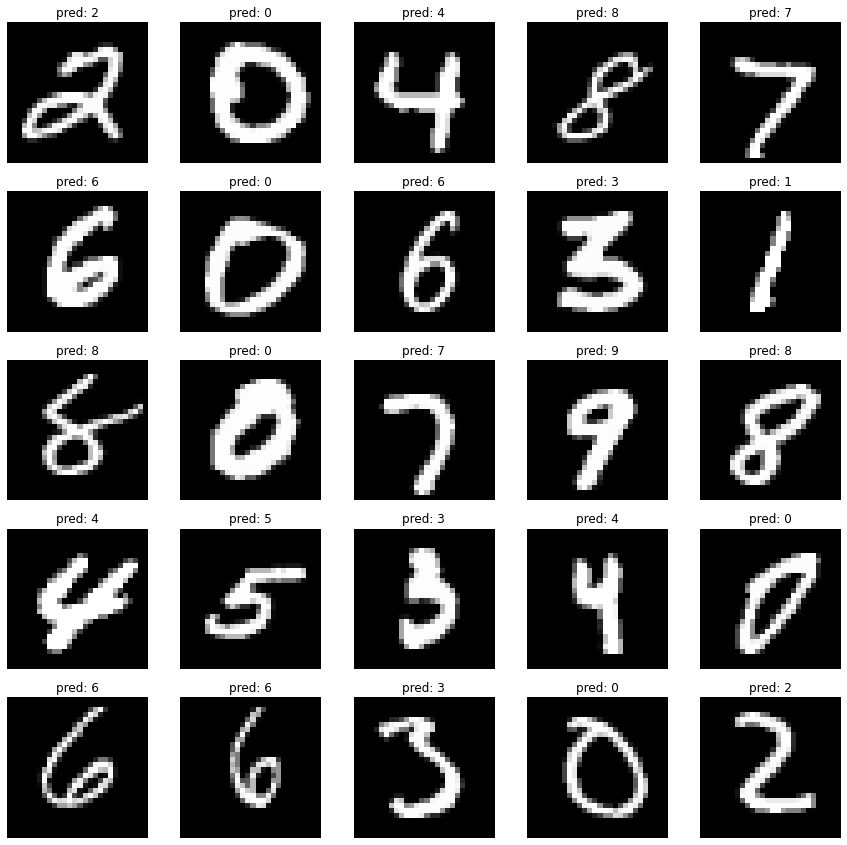

In [19]:
# Try our model

res = model.predict(ds_test)

yhat = res[:128]
yhat = list(map(np.argmax, yhat))
images = list(ds_test)[0][0]
images = list(map(np.squeeze, images))

fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(15, 15))

for i in range(25):
  axs[i // 5, i % 5].imshow(images[i], cmap='gray')
  axs[i // 5, i % 5].set_title(f'pred: {yhat[i]}')
  axs[i // 5, i % 5].axis('off')

fig.show()

# Feature Map and Filter Visualization For CNN Layers

Feature Visualization translates the internal features present in an image into visually perceptible or recognizable image patterns. Feature visualization will help us understand the learned features explicitly.

## **Visualizing Filters or Feature Detectors in a CNN**

CNN uses learned filters to convolve the feature maps from the previous layer. Filters are two- dimensional weights and these weights have a spatial relationship with each other.


---


Visualizing the filters:

1.    Iterate through all the layers of the model using *model.layers*
2.    If the layer is a convolutional layer, then extract the weights and bias values using *get_weights()* for that layer.
3.    Normalize the weights for the filters between 0 and 1
4.    Plot the filters for each of the convolutional layers and all the channels. For Color image, you will have three channels for RGB. For a grayscale image, the number of channels will be 1

Layer conv2d_2 filters (3, 3, 1, 32)
Layer conv2d_3 filters (3, 3, 32, 16)


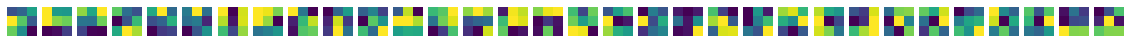

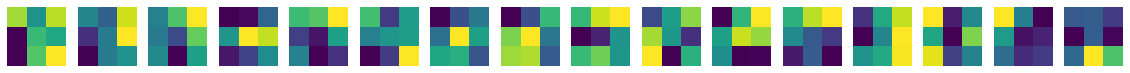

In [51]:
# Visualizing Filters

# Go through all the layers of the model
# This is not important in our case because we only have one conv layer
for layer in model.layers:
  if 'conv' in layer.name:
    weights, bias= layer.get_weights()
    print(f'Layer {layer.name} filters {weights.shape}')
    
    # normalize filter values between  0 and 1 for visualization
    f_min, f_max = weights.min(), weights.max()
    #print(f_min, f_max)
    filters = (weights - f_min) / (f_max - f_min)  
    #print(filters.shape[3])
   
    n_filters = filters.shape[-1]  # number of filters

    fig, axs = plt.subplots(nrows=1, ncols=n_filters, figsize=(20, 20))
    for i in range(n_filters):
      axs[i].imshow(filters[:, :, 0, i], cmap='viridis')
      axs[i].axis('off')
    fig.show()

## Visualizing Feature maps or Activation maps generated in a CNN
Feature maps are generated by applying Filters or Feature detectors to the input image or the feature map output of the prior layers. Feature map visualization will provide insight into the internal representations for specific input for each of the Convolutional layers in the model.



---



Visualizing the feature maps:

1.    Define a new model, visualization_model that will take an image as the input. The output of the model will be feature maps, which are an intermediate representation for all layers after the first layer. This is based on the model we have used for training.

2.    Run an input image through the visualization model to obtain all
intermediate representations for the input image. This will let us  view the Feature map to understand which features were prominent to classify the image.

3.    Create the plot for all of the convolutional layers and the max pool layers but not for the fully connected layer. For plotting the Feature maps, retrieve the layer name for each of the layers in the model.

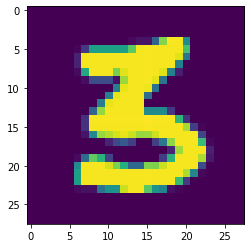

In [65]:
# Obtain a sample image from the dataset
test_image = list(ds_test)[0][0][8]

plt.imshow(np.squeeze(test_image))

1/1 [==============================] - 0s 82ms/step
Layer conv2d_2 outputs (1, 24, 24, 16)
Layer conv2d_3 outputs (1, 12, 12, 16)


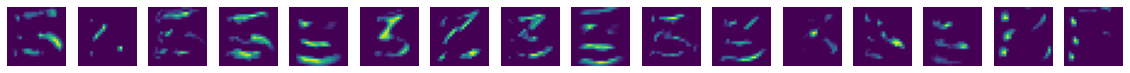

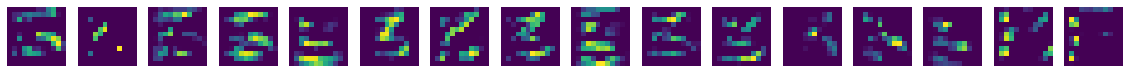

In [66]:
test_image = tf.expand_dims(test_image, 0)

# Define a new Model, Input= image 
# Output= intermediate representations for all layers in the  
# previous model after the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Let's run input image through our vislauization network
# to obtain all intermediate representations for the image.
successive_feature_maps = visualization_model.predict(test_image)

# Retrieve the names of the layers to print
layer_names = [layer.name for layer in model.layers]

for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  # Plot Feature maps for the conv / maxpool layers, not the fully-connected layers
  if len(feature_map.shape) == 4:
    print(f'Layer {layer_name} outputs {feature_map.shape}')
   
    n_features = feature_map.shape[-1]  # number of features in the feature map

    fig, axs = plt.subplots(nrows=1, ncols=n_features, figsize=(20, 20))
    for i in range(n_features):
      x = feature_map[0, :, :, i]
      # normalize filter values between  0 and 1 for visualization
      x /= x.max()
      axs[i].imshow(x, cmap='viridis')
      axs[i].axis('off')
    fig.show()

As a rule of thumb, bright areas in the feature map indicate the features that are important for the network to make a decision.
For example, here it is clear that the edges and the horizontal lines in the number 3 are essential for classification.